# Air Quality Data EDA - Multan AQI Features

This notebook analyzes the engineered air quality and weather data from Hopsworks feature store.

## Dataset Overview
- **Source**: Hopsworks Feature Store (multan_aqi_features)
- **Records**: 538 observations 
- **Features**: 127 engineered features
- **Time Range**: June 16, 2025 - July 8, 2025

## Modeling Approach
- **🎯 Goal**: Accurate US AQI prediction for Multan
- **🔧 Method**: Train ML model to predict PM2.5 & PM10 → Calculate AQI via EPA formula
- **📊 ML Targets**: pm2_5, pm10 concentrations (µg/m³)
- **✅ Success Metric**: How well calculated AQI matches actual AQI values

## Feature Categories
1. **Raw Air Quality**: pm2_5, pm10, co, no2, so2, o3, nh3
2. **AQI Calculations**: pm2_5_aqi, pm10_aqi, us_aqi, openweather_aqi
3. **Weather Data**: temperature, humidity, pressure, wind_speed, wind_direction
4. **Time Features**: Cyclical encodings (hour, day, month, etc.)
5. **Lag Features**: 1h-72h historical values
6. **Rolling Statistics**: 3h-24h windows (mean, std, min, max)
7. **Engineered Features**: Interactions, squared terms, categorical flags


# Air Quality Data EDA

This notebook analyzes the engineered air quality and weather data from Hopsworks feature store that will be used for modeling.

**EDA Focus**: Understanding relationships that help predict PM2.5 and PM10 concentrations accurately, which leads to better AQI predictions.

## 1. Data Overview
Loading and examining the basic structure of our modeling dataset from Hopsworks.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hopsworks
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import configuration
from config import HOPSWORKS_CONFIG

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
# Connect to Hopsworks and load data
print("Connecting to Hopsworks...")
project = hopsworks.login(api_key_value=HOPSWORKS_CONFIG["api_key"], project=HOPSWORKS_CONFIG["project_name"])
fs = project.get_feature_store()

print("Loading feature group data...")
fg = fs.get_feature_group(HOPSWORKS_CONFIG["feature_group_name"], version=1)
df = fg.read()

print(f"Successfully loaded {len(df)} records from Hopsworks")
print(f"Date range: {df['time'].min()} to {df['time'].max()}")


Connecting to Hopsworks...
2025-07-09 03:04:33,470 INFO: Initializing external client
2025-07-09 03:04:33,470 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-07-09 03:04:37,344 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1238191
Loading feature group data...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.57s) 
Successfully loaded 544 records from Hopsworks
Date range: 2025-06-16 00:00:00+00:00 to 2025-07-08 21:10:16+00:00


In [3]:
# Fix column references and prepare data
# The actual timestamp column is called 'time' not 'timestamp'
print("Data preparation and column check...")
print(f"Time column: {'time' if 'time' in df.columns else 'timestamp not found'}")
print(f"Date range: {df['time'].min()} to {df['time'].max()}")

# Ensure time is datetime
if df['time'].dtype == 'object':
    df['time'] = pd.to_datetime(df['time'])

# Sort by time
df = df.sort_values('time').reset_index(drop=True)
print("✓ Data sorted by time")



Data preparation and column check...
Time column: time
Date range: 2025-06-16 00:00:00+00:00 to 2025-07-08 21:10:16+00:00
✓ Data sorted by time


In [4]:
# Basic dataset information
print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(f"Duration: {(df['time'].max() - df['time'].min()).days} days")
print()

print("COLUMNS:")
for i, col in enumerate(df.columns):
    print(f"{i+1:2d}. {col:<25} {str(df[col].dtype):<15}")

print()
print("FEATURE TYPES:")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'time' in numeric_cols:
    numeric_cols.remove('time')
datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric features ({len(numeric_cols)}): {numeric_cols}")
print(f"Datetime features ({len(datetime_cols)}): {datetime_cols}")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")


DATASET OVERVIEW
Shape: 544 rows × 127 columns
Memory usage: 0.56 MB
Duration: 22 days

COLUMNS:
 1. time                      datetime64[us, Etc/UTC]
 2. carbon_monoxide           float64        
 3. no                        float64        
 4. nitrogen_dioxide          float64        
 5. ozone                     float64        
 6. sulphur_dioxide           float64        
 7. pm2_5                     float64        
 8. pm10                      float64        
 9. nh3                       float64        
10. openweather_aqi           float64        
11. pm2_5_aqi                 float64        
12. pm10_aqi                  float64        
13. us_aqi                    float64        
14. temperature               float64        
15. humidity                  float64        
16. pressure                  float64        
17. wind_speed                float64        
18. wind_direction            float64        
19. hour_sin                  float64        
20. hour_cos         

In [5]:
# Display first and last few records
print("=" * 50)
print("SAMPLE DATA")
print("=" * 50)
print("\nFirst 5 records:")
display(df.head())

print("\nLast 5 records:")
display(df.tail())

print("\nRandom 5 records:")
display(df.sample(5))


SAMPLE DATA

First 5 records:


,time,carbon_monoxide,no,nitrogen_dioxide,ozone,sulphur_dioxide,pm2_5,pm10,nh3,openweather_aqi,...,is_high_co,so2_squared,so2_change_rate,is_high_so2,temp_humidity_interaction,temp_wind_interaction,pm2_5_temp_interaction,pm2_5_humidity_interaction,wind_pm2_5_interaction,time_str
0,2025-06-16 00:00:00+00:00,258.82,0.00,5.28,49.89,0.91,52.70,136.51,51.28,4.0,...,0.0,0.8281,0.021978,0.0,17637.22,0.0000,16025.5430,3056.60,0.0000,2025-06-16 00:00:00
1,2025-06-16 01:00:00+00:00,270.30,0.00,5.74,45.52,0.93,53.37,138.53,52.39,4.0,...,0.0,0.8649,0.021978,0.0,17637.22,626.4254,16229.2833,3095.46,109.9422,2025-06-16 01:00:00
2,2025-06-16 02:00:00+00:00,291.42,0.10,6.37,42.10,1.04,54.34,144.76,50.86,4.0,...,0.0,1.0816,0.118280,0.0,17579.22,0.0000,16469.9106,3151.72,0.0000,2025-06-16 02:00:00
3,2025-06-16 03:00:00+00:00,313.30,0.38,6.93,42.22,1.20,55.46,154.77,47.67,4.0,...,0.0,1.4400,0.153846,0.0,20003.94,936.5481,16809.3714,3660.36,171.3714,2025-06-16 03:00:00
4,2025-06-16 04:00:00+00:00,239.89,0.13,4.41,72.36,2.14,58.39,185.78,30.98,4.0,...,0.0,4.5796,0.783333,0.0,20003.94,624.3654,17697.4251,3853.74,120.2834,2025-06-16 04:00:00



Last 5 records:


,time,carbon_monoxide,no,nitrogen_dioxide,ozone,sulphur_dioxide,pm2_5,pm10,nh3,openweather_aqi,...,is_high_co,so2_squared,so2_change_rate,is_high_so2,temp_humidity_interaction,temp_wind_interaction,pm2_5_temp_interaction,pm2_5_humidity_interaction,wind_pm2_5_interaction,time_str
539,2025-07-08 17:10:43+00:00,156.32,0.0,3.13,56.06,1.96,22.73,81.10,9.98,3.0,...,0.0,3.8416,0.0,0.0,2240.0,98.88,727.36,1591.10,70.2357,2025-07-08 17:10:43
540,2025-07-08 18:14:59+00:00,151.84,0.0,3.00,55.13,2.07,23.63,87.94,9.79,3.0,...,0.0,4.2849,0.0,0.0,2170.0,95.79,732.53,1654.10,73.0167,2025-07-08 18:14:59
541,2025-07-08 19:08:47+00:00,144.11,0.0,2.80,54.48,2.17,23.77,91.70,9.43,3.0,...,0.0,4.7089,0.0,0.0,2170.0,95.79,736.87,1663.90,73.4493,2025-07-08 19:08:47
542,2025-07-08 20:11:53+00:00,137.68,0.0,2.60,53.84,2.06,23.78,93.83,9.55,3.0,...,0.0,4.2436,0.0,0.0,2220.0,123.60,713.40,1759.72,97.9736,2025-07-08 20:11:53
543,2025-07-08 21:10:16+00:00,131.74,0.0,2.38,53.21,1.82,23.93,95.80,9.79,3.0,...,0.0,3.3124,0.0,0.0,2294.0,127.72,741.83,1770.82,98.5916,2025-07-08 21:10:16



Random 5 records:


,time,carbon_monoxide,no,nitrogen_dioxide,ozone,sulphur_dioxide,pm2_5,pm10,nh3,openweather_aqi,...,is_high_co,so2_squared,so2_change_rate,is_high_so2,temp_humidity_interaction,temp_wind_interaction,pm2_5_temp_interaction,pm2_5_humidity_interaction,wind_pm2_5_interaction,time_str
177,2025-06-23 09:00:00+00:00,152.91,0.03,0.86,84.11,1.91,31.73,103.92,8.83,4.0,...,0.0,3.6481,-0.099057,0.0,16944.95,1269.3308,8367.7244,1493.8,111.8992,2025-06-23 09:00:00
213,2025-06-24 21:00:00+00:00,162.93,0.00,1.69,66.07,1.78,24.63,102.38,17.98,4.0,...,0.0,3.1684,0.171053,0.0,16944.95,1269.3308,8367.7244,1493.8,111.8992,2025-06-24 21:00:00
223,2025-06-25 07:00:00+00:00,142.67,0.03,0.68,87.93,3.05,36.94,133.38,8.20,4.0,...,0.0,9.3025,-0.386318,0.0,16944.95,1269.3308,8367.7244,1493.8,111.8992,2025-06-25 07:00:00
200,2025-06-24 08:00:00+00:00,160.32,0.06,0.44,92.70,2.09,33.64,106.54,7.15,4.0,...,0.0,4.3681,-0.293919,0.0,16944.95,1269.3308,8367.7244,1493.8,111.8992,2025-06-24 08:00:00
247,2025-06-26 07:00:00+00:00,136.36,0.04,0.80,75.52,1.49,31.25,138.12,11.33,4.0,...,0.0,2.2201,-0.143678,0.0,16944.95,1269.3308,8367.7244,1493.8,111.8992,2025-06-26 07:00:00


In [6]:
# Summary statistics for numeric features
print("=" * 50)
print("SUMMARY STATISTICS")
print("=" * 50)
display(df.describe())

print("\nAIR QUALITY FEATURES SUMMARY:")
aqi_features = ['pm2_5', 'pm10', 'co', 'no2', 'so2', 'o3', 'us_aqi', 'pm2_5_aqi', 'pm10_aqi']
aqi_present = [col for col in aqi_features if col in df.columns]
if aqi_present:
    display(df[aqi_present].describe())

print("\nWEATHER FEATURES SUMMARY:")
weather_features = ['temperature', 'feels_like', 'humidity', 'pressure', 'visibility', 'wind_speed', 'wind_direction', 'cloud_cover']
weather_present = [col for col in weather_features if col in df.columns]
if weather_present:
    display(df[weather_present].describe())


SUMMARY STATISTICS


,carbon_monoxide,no,nitrogen_dioxide,ozone,sulphur_dioxide,pm2_5,pm10,nh3,openweather_aqi,pm2_5_aqi,...,co_change_rate,is_high_co,so2_squared,so2_change_rate,is_high_so2,temp_humidity_interaction,temp_wind_interaction,pm2_5_temp_interaction,pm2_5_humidity_interaction,wind_pm2_5_interaction
count,544.000000,544.00000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,...,544.000000,544.0,544.000000,544.000000,544.0,544.000000,544.000000,544.000000,544.000000,544.000000
mean,230.218934,0.07625,2.669301,77.041636,2.400349,35.273382,105.936985,16.946654,3.551471,100.115809,...,0.000460,0.0,8.101327,0.016916,0.0,11659.317096,832.386762,8600.900442,1849.521875,121.490410
std,105.823981,0.13059,2.228469,22.944756,1.530999,15.200838,36.474383,11.330103,0.613775,32.170177,...,0.052060,0.0,10.495567,0.184994,0.0,6510.126150,586.723749,6135.507151,627.799849,66.859251
min,120.300000,0.00000,0.380000,30.900000,0.300000,0.000000,0.000000,3.100000,1.000000,0.000000,...,-0.298443,0.0,0.090000,-0.386318,0.0,1103.250000,0.000000,518.500000,609.500000,0.000000
25%,148.767500,0.00000,1.077500,61.847500,1.227500,23.215000,83.067500,8.632500,3.000000,74.000000,...,-0.013790,0.0,1.506775,-0.061357,0.0,2216.250000,168.920000,1604.460000,1493.800000,111.899200
50%,189.975000,0.02000,1.930000,72.685000,2.095000,31.780000,101.290000,13.295000,4.000000,92.000000,...,0.000000,0.0,4.389050,0.000000,0.0,15557.045000,975.173100,8367.724400,1493.800000,111.899200
75%,293.647500,0.10000,3.437500,87.802500,3.190000,45.742500,126.182500,22.607500,4.000000,126.000000,...,0.018381,0.0,10.176100,0.026220,0.0,16944.950000,1269.330800,12624.530775,2062.355000,140.865300
max,558.030000,1.23000,12.610000,154.010000,8.540000,82.800000,222.030000,60.860000,5.000000,165.000000,...,0.223773,0.0,72.931600,1.383178,0.0,20003.940000,2908.473400,25061.076000,4056.480000,498.115200



AIR QUALITY FEATURES SUMMARY:


,pm2_5,pm10,us_aqi,pm2_5_aqi,pm10_aqi
count,544.000000,544.000000,544.000000,544.000000,544.000000
mean,35.273382,105.936985,99.806985,100.115809,75.545956
std,15.200838,36.474383,32.805660,32.170177,19.592856
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.215000,83.067500,74.000000,74.000000,65.000000
50%,31.780000,101.290000,92.000000,92.000000,74.000000
75%,45.742500,126.182500,126.000000,126.000000,86.000000
max,82.800000,222.030000,165.000000,165.000000,134.000000



WEATHER FEATURES SUMMARY:


,temperature,humidity,pressure,wind_speed,wind_direction
count,544.000000,544.000000,544.000000,544.000000,544.000000
mean,228.359632,52.939338,993.915441,3.663015,148.676471
std,124.853436,9.491200,1.686317,1.843650,71.734279
min,28.000000,25.000000,990.000000,0.000000,0.000000
25%,40.000000,49.000000,993.000000,3.090000,130.000000
50%,308.090000,55.000000,993.000000,4.120000,130.000000
75%,308.090000,55.000000,995.000000,4.120000,180.000000
max,316.090000,78.000000,999.000000,17.490000,360.000000


## 2. Time Series Analysis

Analyzing temporal patterns in PM concentrations (our prediction targets) and derived AQI values.

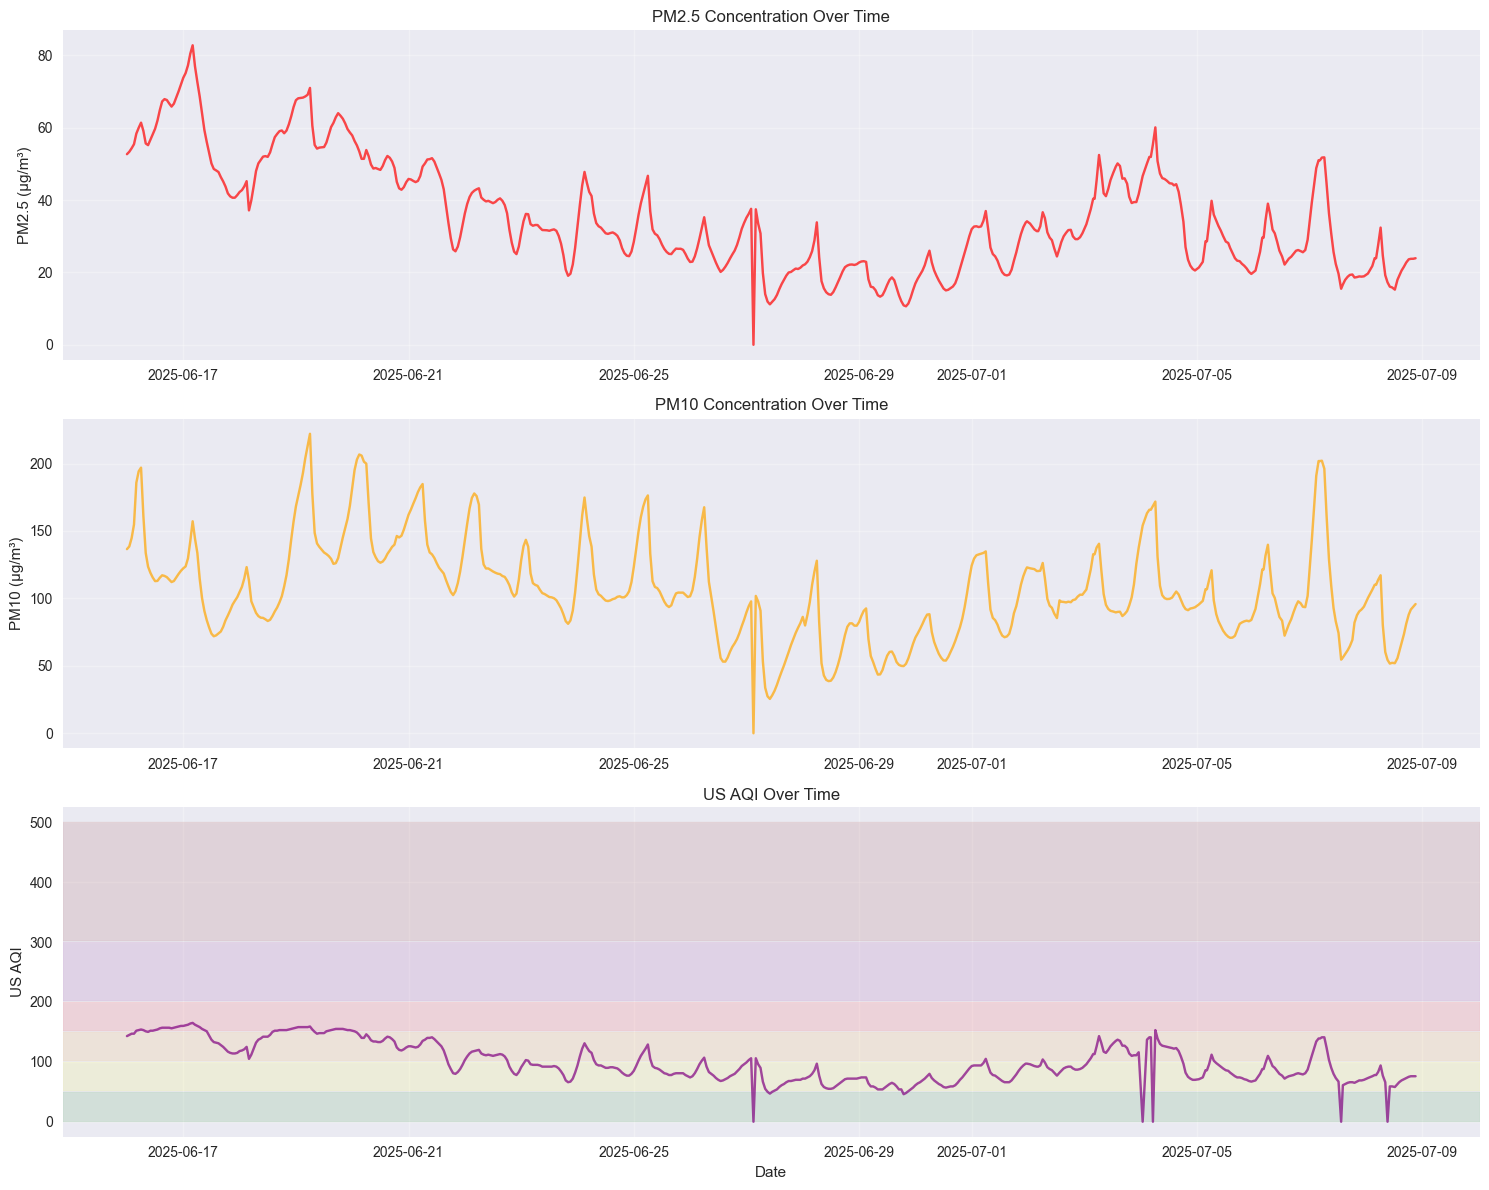

Time Series Summary (ML Targets + Goal Metric):
PM2.5 (ML Target): 0.0 - 82.8 µg/m³
PM10 (ML Target):  0.0 - 222.0 µg/m³
US AQI (Goal Metric): 0.0 - 165.0

Modeling Approach: Predict PM concentrations → Calculate AQI → Evaluate AQI accuracy


In [7]:
# Time series plots for key air quality metrics
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# PM2.5 over time
axes[0].plot(df['time'], df['pm2_5'], alpha=0.7, color='red')
axes[0].set_title('PM2.5 Concentration Over Time')
axes[0].set_ylabel('PM2.5 (µg/m³)')
axes[0].grid(True, alpha=0.3)

# PM10 over time  
axes[1].plot(df['time'], df['pm10'], alpha=0.7, color='orange')
axes[1].set_title('PM10 Concentration Over Time')
axes[1].set_ylabel('PM10 (µg/m³)')
axes[1].grid(True, alpha=0.3)

# US AQI over time
axes[2].plot(df['time'], df['us_aqi'], alpha=0.7, color='purple')
axes[2].set_title('US AQI Over Time')
axes[2].set_ylabel('US AQI')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

# Add AQI category colors as background
aqi_levels = [
    (0, 50, 'green', 'Good'),
    (51, 100, 'yellow', 'Moderate'), 
    (101, 150, 'orange', 'Unhealthy for Sensitive'),
    (151, 200, 'red', 'Unhealthy'),
    (201, 300, 'purple', 'Very Unhealthy'),
    (301, 500, 'maroon', 'Hazardous')
]

for min_val, max_val, color, label in aqi_levels:
    axes[2].axhspan(min_val, max_val, alpha=0.1, color=color, label=label)

plt.tight_layout()
plt.show()

# Time series summary - ML TARGETS and GOAL METRIC
print(f"Time Series Summary (ML Targets + Goal Metric):")
print(f"PM2.5 (ML Target): {df['pm2_5'].min():.1f} - {df['pm2_5'].max():.1f} µg/m³")
print(f"PM10 (ML Target):  {df['pm10'].min():.1f} - {df['pm10'].max():.1f} µg/m³") 
print(f"US AQI (Goal Metric): {df['us_aqi'].min():.1f} - {df['us_aqi'].max():.1f}")
print(f"\nModeling Approach: Predict PM concentrations → Calculate AQI → Evaluate AQI accuracy")


## 3. Feature Analysis and Correlations

Examining relationships between air quality and weather features.

Analyzing correlations for 10 key features:
['pm2_5', 'pm10', 'temperature', 'humidity', 'pressure', 'wind_speed', 'carbon_monoxide', 'nitrogen_dioxide', 'ozone', 'sulphur_dioxide']


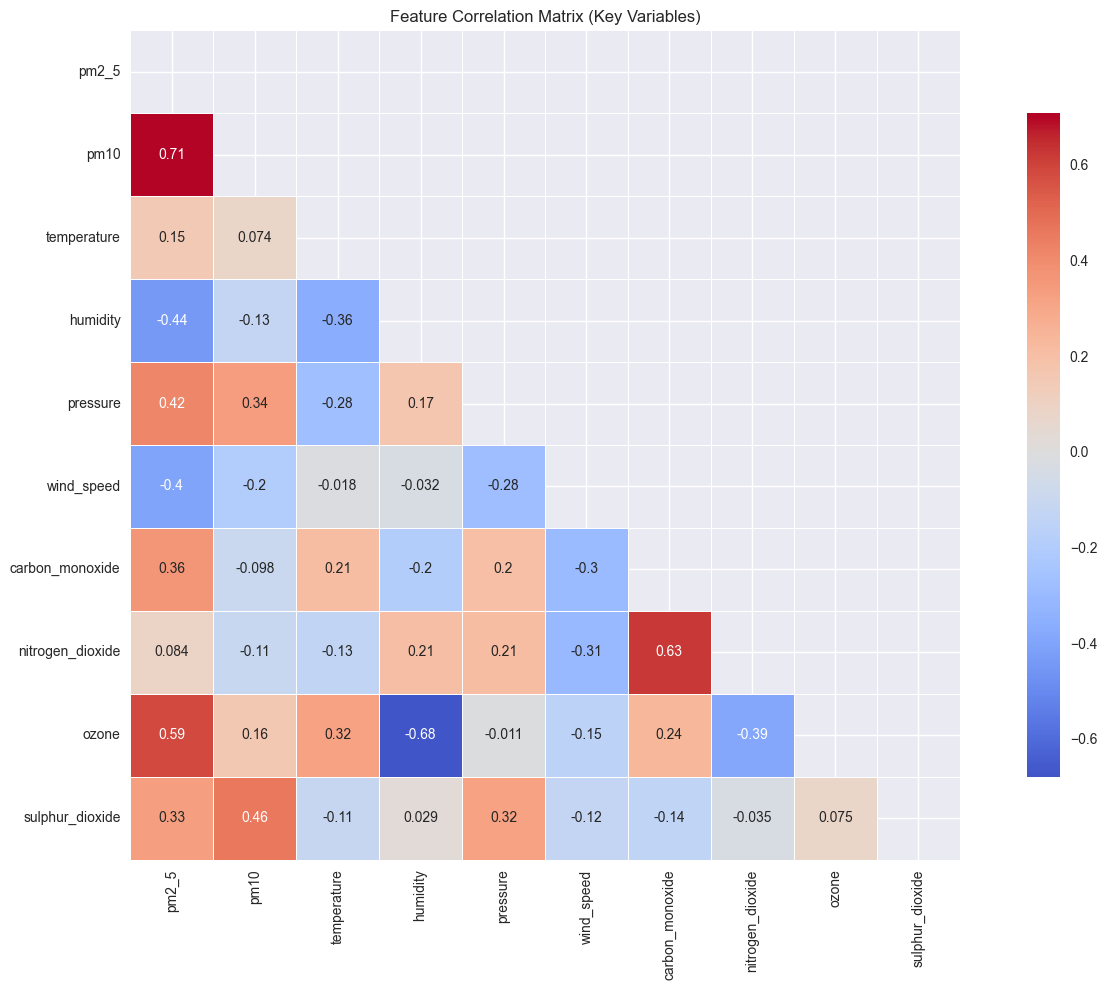


Strongest correlations with PM2.5 (ML Target):
  pm10                : 0.707
  ozone               : 0.587
  humidity            : 0.444
  pressure            : 0.417
  wind_speed          : 0.399
  carbon_monoxide     : 0.362
  sulphur_dioxide     : 0.330

Strongest correlations with PM10 (ML Target):
  pm2_5               : 0.707
  sulphur_dioxide     : 0.460
  pressure            : 0.336
  wind_speed          : 0.200
  ozone               : 0.155
  humidity            : 0.125
  nitrogen_dioxide    : 0.109

🎯 CORRELATION FOCUS:
Understanding which environmental factors help predict PM concentrations accurately
Better PM predictions → More accurate AQI calculations


In [8]:
# Correlation analysis - ML targets + environmental predictors
key_features = [
    'pm2_5', 'pm10',  # ML targets
    'temperature', 'humidity', 'pressure', 'wind_speed',  # Weather predictors
    'carbon_monoxide', 'nitrogen_dioxide', 'ozone', 'sulphur_dioxide'  # Pollutant predictors
]
# Note: Excluding us_aqi since it's derived from PM targets

# Filter features that exist in our dataset
available_features = [col for col in key_features if col in df.columns]
print(f"Analyzing correlations for {len(available_features)} key features:")
print(available_features)

# Calculate correlation matrix
corr_matrix = df[available_features].corr()

# Create correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix (Key Variables)')
plt.tight_layout()
plt.show()

# Focus on ML TARGETS (PM concentrations) - what we need to predict well
print("\nStrongest correlations with PM2.5 (ML Target):")
pm25_corr = corr_matrix['pm2_5'].abs().sort_values(ascending=False)
for feature, corr in pm25_corr.head(8).items():
    if feature != 'pm2_5':
        print(f"  {feature:<20}: {corr:.3f}")

print("\nStrongest correlations with PM10 (ML Target):")
pm10_corr = corr_matrix['pm10'].abs().sort_values(ascending=False)
for feature, corr in pm10_corr.head(8).items():
    if feature != 'pm10':
        print(f"  {feature:<20}: {corr:.3f}")

print("\n🎯 CORRELATION FOCUS:")
print("Understanding which environmental factors help predict PM concentrations accurately")
print("Better PM predictions → More accurate AQI calculations")


In [9]:
# Focus on ML TARGETS (PM concentrations) - what affects our predictions
print("="*60)
print("ML TARGET CORRELATION ANALYSIS")
print("="*60)

target_features = ['pm2_5', 'pm10']
predictor_features = ['temperature', 'humidity', 'pressure', 'wind_speed', 
                     'carbon_monoxide', 'nitrogen_dioxide', 'ozone', 'sulphur_dioxide']

available_predictors = [col for col in predictor_features if col in df.columns]

for target in target_features:
    if target in df.columns:
        print(f"\nStrongest correlations with {target.upper()} (Target Variable):")
        target_corr = df[[target] + available_predictors].corr()[target].abs().sort_values(ascending=False)
        for feature, corr in target_corr.head(6).items():
            if feature != target:
                print(f"  {feature:<20}: {corr:.3f}")

print(f"\n[EDA Focus: Understanding what predicts PM concentrations well]")
print(f"[Goal: Better PM predictions → More accurate AQI calculations]")


ML TARGET CORRELATION ANALYSIS

Strongest correlations with PM2_5 (Target Variable):
  ozone               : 0.587
  humidity            : 0.444
  pressure            : 0.417
  wind_speed          : 0.399
  carbon_monoxide     : 0.362

Strongest correlations with PM10 (Target Variable):
  sulphur_dioxide     : 0.460
  pressure            : 0.336
  wind_speed          : 0.200
  ozone               : 0.155
  humidity            : 0.125

[EDA Focus: Understanding what predicts PM concentrations well]
[Goal: Better PM predictions → More accurate AQI calculations]


## 4. AQI Dominance Analysis

**Key Question**: Which pollutants actually drive AQI values? 

Since EPA AQI = MAX(individual pollutant AQIs), we need to check if other criteria pollutants sometimes create higher AQI than PM2.5/PM10. This validates our modeling approach of using only PM concentrations.

**EPA Criteria Pollutants Analyzed**: PM2.5, PM10, O3, CO, NO2, SO2  
*(Only these 6 pollutants have official EPA AQI breakpoints and affect AQI calculations)*


In [10]:
# EPA AQI Calculation Functions for All Pollutants
def calculate_aqi_from_concentration(concentration, breakpoints):
    """Calculate AQI from pollutant concentration using EPA breakpoints"""
    if pd.isna(concentration) or concentration < 0:
        return 0
    
    for i, (c_low, c_high, aqi_low, aqi_high) in enumerate(breakpoints):
        if c_low <= concentration <= c_high:
            # Linear interpolation within the bracket
            aqi = ((aqi_high - aqi_low) / (c_high - c_low)) * (concentration - c_low) + aqi_low
            return round(aqi)
    
    # If concentration exceeds highest breakpoint, use hazardous level
    return 500

# EPA AQI Breakpoints (concentration ranges and corresponding AQI ranges)
EPA_BREAKPOINTS = {
    'pm2_5': [  # µg/m³, 24-hour average
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 500.4, 301, 500)
    ],
    'pm10': [  # µg/m³, 24-hour average  
        (0, 54, 0, 50),
        (55, 154, 51, 100),
        (155, 254, 101, 150),
        (255, 354, 151, 200),
        (355, 424, 201, 300),
        (425, 604, 301, 500)
    ],
    'ozone': [  # ppb, 8-hour average (converting from µg/m³ if needed)
        (0, 54, 0, 50),
        (55, 70, 51, 100),
        (71, 85, 101, 150),
        (86, 105, 151, 200),
        (106, 200, 201, 300)
    ],
    'carbon_monoxide': [  # ppm, 8-hour average
        (0.0, 4.4, 0, 50),
        (4.5, 9.4, 51, 100),
        (9.5, 12.4, 101, 150),
        (12.5, 15.4, 151, 200),
        (15.5, 30.4, 201, 300),
        (30.5, 50.4, 301, 500)
    ],
    'nitrogen_dioxide': [  # ppb, 1-hour average
        (0, 53, 0, 50),
        (54, 100, 51, 100),
        (101, 360, 101, 150),
        (361, 649, 151, 200),
        (650, 1249, 201, 300),
        (1250, 2049, 301, 500)
    ],
    'sulphur_dioxide': [  # ppb, 1-hour average
        (0, 35, 0, 50),
        (36, 75, 51, 100),
        (76, 185, 101, 150),
        (186, 304, 151, 200),
        (305, 604, 201, 300),
        (605, 1004, 301, 500)
    ]
}

print("EPA AQI Calculation Functions Loaded")
print(f"EPA Criteria Pollutants (official breakpoints): {list(EPA_BREAKPOINTS.keys())}")

# Check which EPA criteria pollutants we have in our data
available_pollutants = []
for pollutant in EPA_BREAKPOINTS.keys():
    if pollutant in df.columns:
        available_pollutants.append(pollutant)
        
print(f"\nEPA criteria pollutants in our dataset: {available_pollutants}")
print(f"Missing from dataset: {[p for p in EPA_BREAKPOINTS.keys() if p not in df.columns]}")
print(f"\nAnalyzing {len(available_pollutants)} pollutants that can affect AQI calculations")


EPA AQI Calculation Functions Loaded
EPA Criteria Pollutants (official breakpoints): ['pm2_5', 'pm10', 'ozone', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide']

EPA criteria pollutants in our dataset: ['pm2_5', 'pm10', 'ozone', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide']
Missing from dataset: []

Analyzing 6 pollutants that can affect AQI calculations


In [11]:
# Calculate individual AQI for each available pollutant
aqi_results = df[['time', 'us_aqi']].copy()

# Unit conversions (if needed)
df_calc = df.copy()

# Convert units for certain pollutants if needed
# Ozone: µg/m³ to ppb (approximate: µg/m³ * 0.5 ≈ ppb at standard conditions)
if 'ozone' in df_calc.columns:
    df_calc['ozone_ppb'] = df_calc['ozone'] * 0.5  # Rough conversion
    
# CO might need conversion from µg/m³ to ppm
if 'carbon_monoxide' in df_calc.columns:
    df_calc['co_ppm'] = df_calc['carbon_monoxide'] * 0.000873  # Rough conversion

print("Calculating individual AQI for each pollutant...")

# Calculate AQI for each pollutant
for pollutant in available_pollutants:
    col_name = f'{pollutant}_individual_aqi'
    
    if pollutant == 'ozone' and 'ozone_ppb' in df_calc.columns:
        concentrations = df_calc['ozone_ppb']
    elif pollutant == 'carbon_monoxide' and 'co_ppm' in df_calc.columns:
        concentrations = df_calc['co_ppm']
    else:
        concentrations = df_calc[pollutant]
    
    aqi_results[col_name] = concentrations.apply(
        lambda x: calculate_aqi_from_concentration(x, EPA_BREAKPOINTS[pollutant])
    )
    
    print(f"✓ {pollutant}: {aqi_results[col_name].min():.0f} - {aqi_results[col_name].max():.0f} AQI")

# Find controlling pollutant (max AQI) for each timestamp
individual_aqi_cols = [col for col in aqi_results.columns if 'individual_aqi' in col]
aqi_results['calculated_max_aqi'] = aqi_results[individual_aqi_cols].max(axis=1)
aqi_results['controlling_pollutant'] = aqi_results[individual_aqi_cols].idxmax(axis=1)

# Clean up pollutant names
aqi_results['controlling_pollutant'] = aqi_results['controlling_pollutant'].str.replace('_individual_aqi', '')

print(f"\nCalculated AQI range: {aqi_results['calculated_max_aqi'].min():.0f} - {aqi_results['calculated_max_aqi'].max():.0f}")
print(f"Current US AQI range: {aqi_results['us_aqi'].min():.0f} - {aqi_results['us_aqi'].max():.0f}")
print(f"Difference: {(aqi_results['calculated_max_aqi'] - aqi_results['us_aqi']).describe()}")


Calculating individual AQI for each pollutant...
✓ pm2_5: 0 - 500 AQI
✓ pm10: 0 - 500 AQI
✓ ozone: 14 - 500 AQI
✓ carbon_monoxide: 1 - 6 AQI
✓ nitrogen_dioxide: 0 - 12 AQI
✓ sulphur_dioxide: 0 - 12 AQI

Calculated AQI range: 18 - 500
Current US AQI range: 0 - 165
Difference: count    544.000000
mean       9.794118
std       63.263152
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      500.000000
dtype: float64


POLLUTANT DOMINANCE ANALYSIS
Controlling Pollutant Frequency:
  pm2_5          : 512 times ( 94.1%)
  pm10           :  24 times (  4.4%)
  ozone          :   8 times (  1.5%)


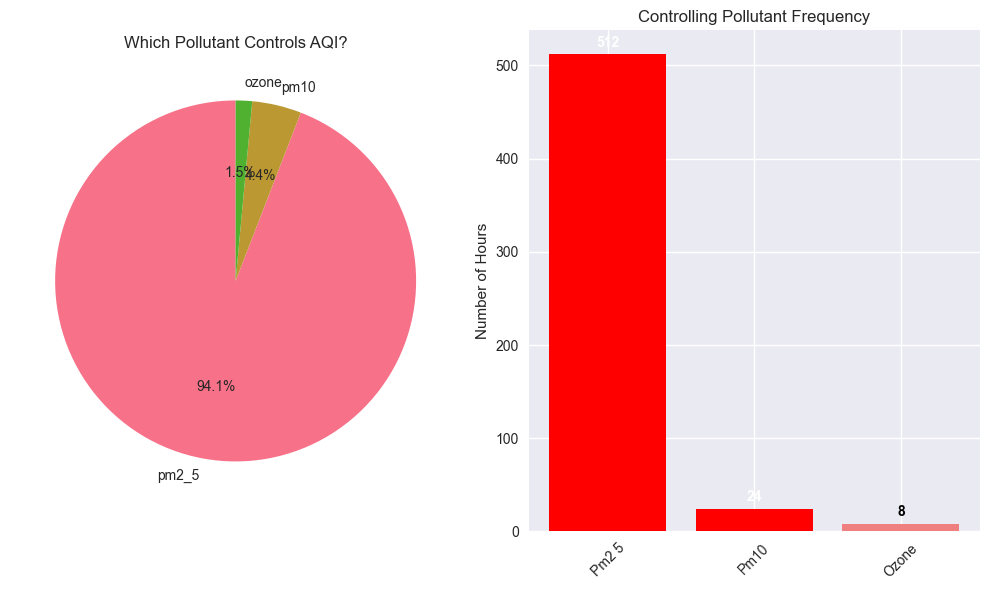


🎯 KEY FINDING:
PM2.5 + PM10 control AQI 536/544 times (98.5%)
Other pollutants control AQI 8/544 times (1.5%)
✅ Current PM-only approach captures most AQI variations


In [12]:
# VISUALIZATION 1: Pollutant Dominance Analysis
print("="*60)
print("POLLUTANT DOMINANCE ANALYSIS")
print("="*60)

# Count which pollutant controls AQI most often
dominance_counts = aqi_results['controlling_pollutant'].value_counts()
dominance_pct = (dominance_counts / len(aqi_results) * 100).round(1)

print("Controlling Pollutant Frequency:")
for pollutant, count in dominance_counts.items():
    pct = dominance_pct[pollutant]
    print(f"  {pollutant:<15}: {count:3d} times ({pct:5.1f}%)")

# Pie chart of dominance
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.pie(dominance_counts.values, labels=dominance_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Which Pollutant Controls AQI?')

# Bar chart for clearer comparison
plt.subplot(1, 2, 2)
bars = plt.bar(range(len(dominance_counts)), dominance_counts.values, 
               color=['red' if x in ['pm2_5', 'pm10'] else 'lightcoral' for x in dominance_counts.index])
plt.xticks(range(len(dominance_counts)), [p.replace('_', ' ').title() for p in dominance_counts.index], rotation=45)
plt.ylabel('Number of Hours')
plt.title('Controlling Pollutant Frequency')

# Highlight PM2.5 and PM10
for i, (pollutant, count) in enumerate(dominance_counts.items()):
    color = 'white' if pollutant in ['pm2_5', 'pm10'] else 'black'
    plt.text(i, count + 5, f'{count}', ha='center', va='bottom', fontweight='bold', color=color)

plt.tight_layout()
plt.show()

# Analysis of PM dominance
pm_dominance = dominance_counts.get('pm2_5', 0) + dominance_counts.get('pm10', 0)
pm_percentage = (pm_dominance / len(aqi_results) * 100)

print(f"\n🎯 KEY FINDING:")
print(f"PM2.5 + PM10 control AQI {pm_dominance}/{len(aqi_results)} times ({pm_percentage:.1f}%)")
print(f"Other pollutants control AQI {len(aqi_results) - pm_dominance}/{len(aqi_results)} times ({100-pm_percentage:.1f}%)")

if pm_percentage >= 80:
    print("✅ Current PM-only approach captures most AQI variations")
else:
    print("⚠️  Consider including other pollutants in modeling")



CONCENTRATION vs AQI ANALYSIS


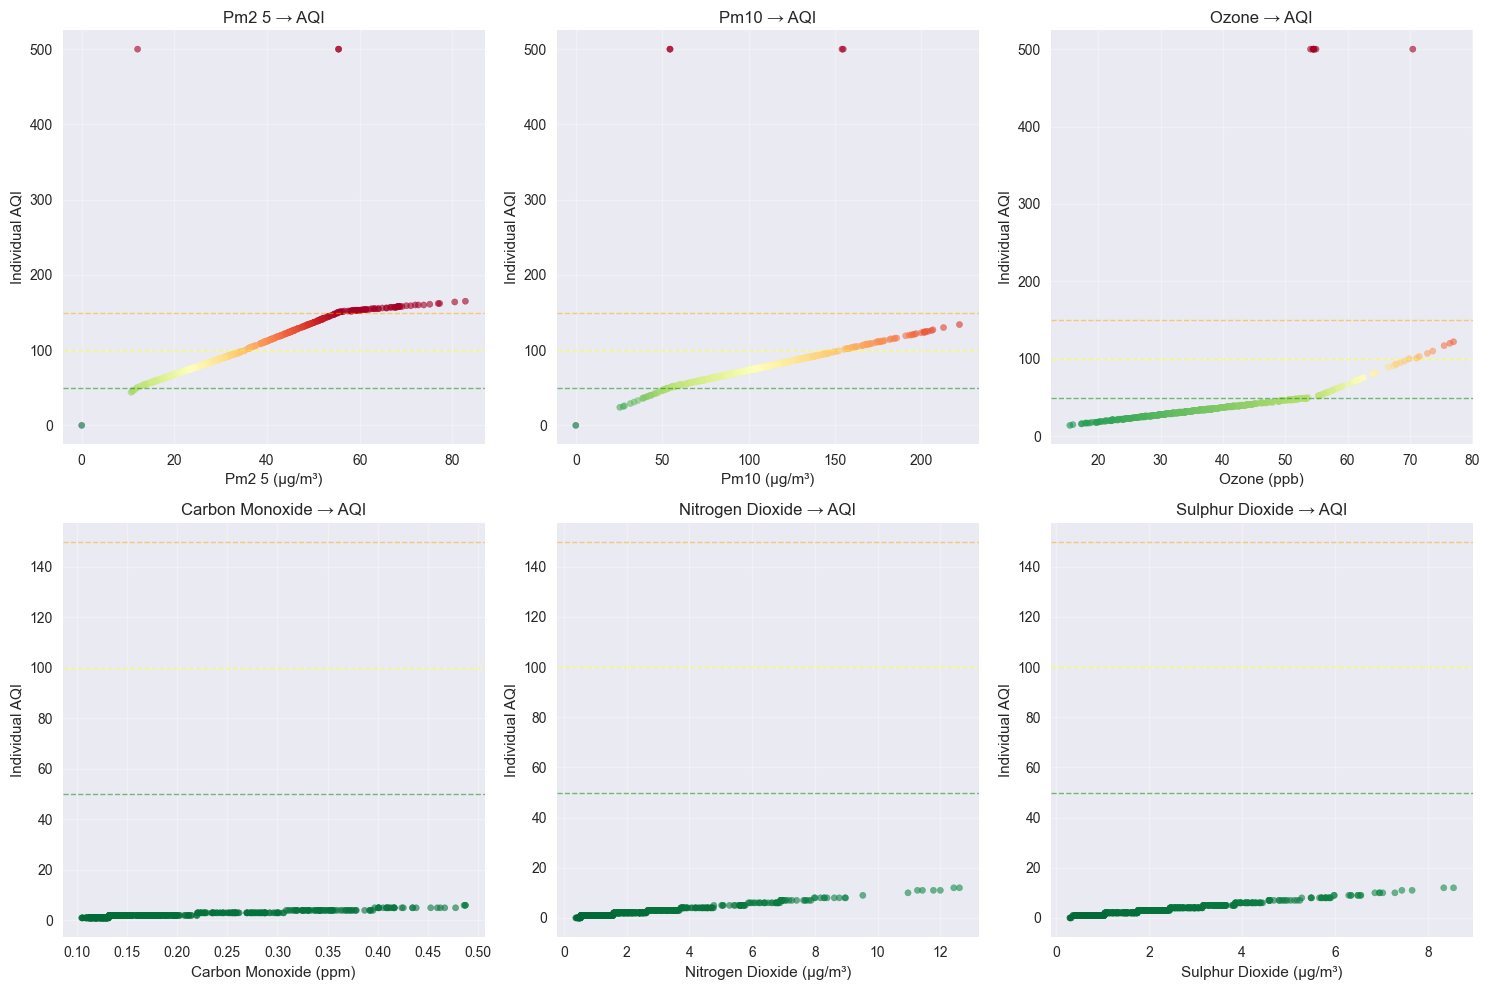


Individual AQI Statistics (EPA Criteria Pollutants):
pm2_5          : Mean=102.5, Max=500.0, >100: 228 times
pm10           : Mean= 79.0, Max=500.0, >100:  63 times
ozone          : Mean= 43.1, Max=500.0, >100:  14 times
carbon_monoxide: Mean=  2.3, Max=  6.0, >100:   0 times
nitrogen_dioxide: Mean=  2.5, Max= 12.0, >100:   0 times
sulphur_dioxide: Mean=  3.4, Max= 12.0, >100:   0 times


In [13]:
# VISUALIZATION 2: Concentration vs AQI Relationships
print("\n" + "="*60)
print("CONCENTRATION vs AQI ANALYSIS")
print("="*60)

# Create scatter plots for EPA criteria pollutants only
num_plots = len(available_pollutants)
cols = 3
rows = (num_plots + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
if rows == 1:
    axes = [axes]  # Make it iterable
axes = axes.flatten()

for i, pollutant in enumerate(available_pollutants):
        
    ax = axes[i]
    
    # Get concentrations and individual AQI
    if pollutant == 'ozone' and 'ozone_ppb' in df_calc.columns:
        conc = df_calc['ozone_ppb']
        unit = 'ppb'
    elif pollutant == 'carbon_monoxide' and 'co_ppm' in df_calc.columns:
        conc = df_calc['co_ppm']
        unit = 'ppm'
    else:
        conc = df_calc[pollutant]
        unit = 'µg/m³'
    
    # All pollutants here are EPA criteria pollutants with AQI calculations
    individual_aqi = aqi_results[f'{pollutant}_individual_aqi']
    
    # Scatter plot with AQI color coding
    scatter = ax.scatter(conc, individual_aqi, alpha=0.6, s=20, 
                        c=individual_aqi, cmap='RdYlGn_r', vmin=0, vmax=150)
    
    ax.set_xlabel(f'{pollutant.replace("_", " ").title()} ({unit})')
    ax.set_ylabel('Individual AQI')
    ax.set_title(f'{pollutant.replace("_", " ").title()} → AQI')
    ax.grid(True, alpha=0.3)
    
    # Add AQI level lines
    ax.axhline(y=50, color='green', linestyle='--', alpha=0.5, linewidth=1)
    ax.axhline(y=100, color='yellow', linestyle='--', alpha=0.5, linewidth=1)
    ax.axhline(y=150, color='orange', linestyle='--', alpha=0.5, linewidth=1)

# Remove empty subplots
for i in range(len(available_pollutants), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Summary statistics for EPA criteria pollutants
print("\nIndividual AQI Statistics (EPA Criteria Pollutants):")
for pollutant in available_pollutants:
    aqi_col = f'{pollutant}_individual_aqi'
    stats = aqi_results[aqi_col].describe()
    print(f"{pollutant:<15}: Mean={stats['mean']:5.1f}, Max={stats['max']:5.1f}, >100: {(aqi_results[aqi_col] > 100).sum():3d} times")



INDIVIDUAL POLLUTANT AQI CONTRIBUTIONS


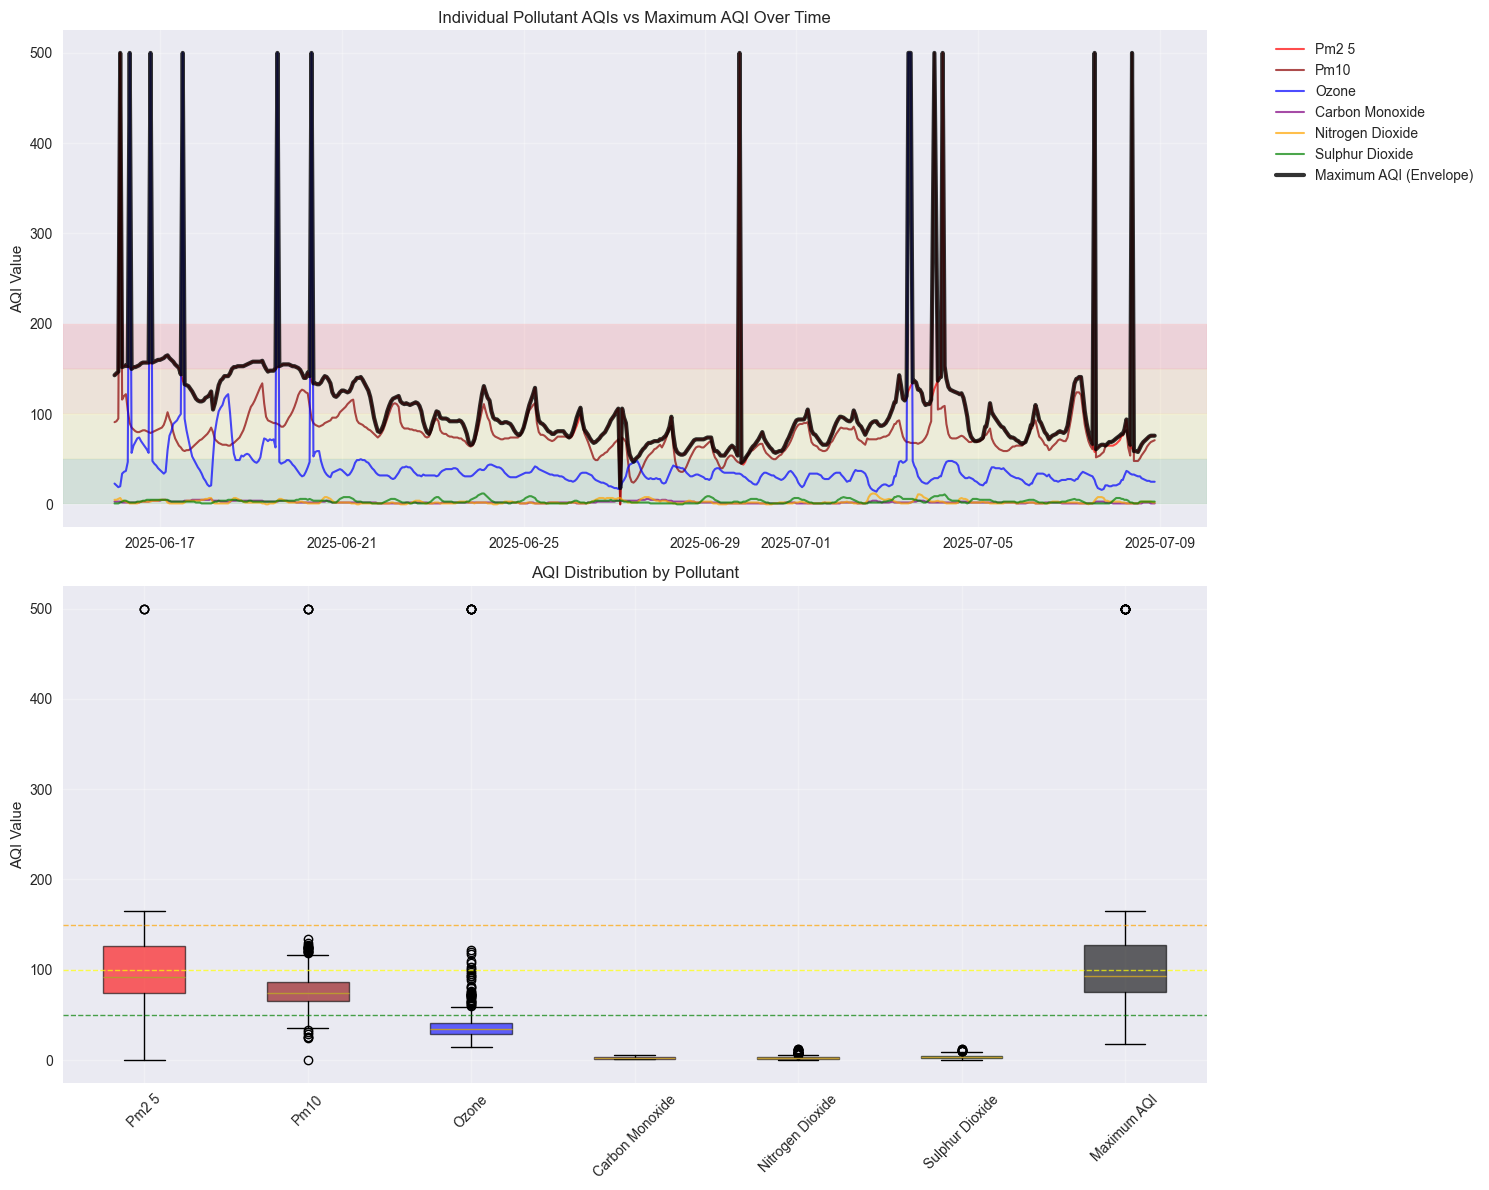


Individual AQI vs Maximum AQI Analysis:
Maximum AQI - Mean: 109.6, Range: 18-500

How often each pollutant reaches within 90% of maximum AQI:
  pm2_5          : 533/544 times ( 98.0%) within 90% of max
  pm10           : 126/544 times ( 23.2%) within 90% of max
  ozone          :  12/544 times (  2.2%) within 90% of max
  carbon_monoxide:   0/544 times (  0.0%) within 90% of max
  nitrogen_dioxide:   0/544 times (  0.0%) within 90% of max
  sulphur_dioxide:   0/544 times (  0.0%) within 90% of max

This shows which pollutants are the 'runners-up' when they don't control AQI


In [14]:
# VISUALIZATION 3A: Individual AQI Contributions vs Maximum AQI
print("\n" + "="*60)
print("INDIVIDUAL POLLUTANT AQI CONTRIBUTIONS")
print("="*60)

# Time series showing all individual AQIs vs the maximum
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: All individual AQIs over time
time_vals = aqi_results['time']
max_aqi_vals = aqi_results['calculated_max_aqi']

# Plot each individual AQI
colors = ['red', 'darkred', 'blue', 'purple', 'orange', 'green']
for i, pollutant in enumerate(available_pollutants):
    aqi_col = f'{pollutant}_individual_aqi'
    if aqi_col in aqi_results.columns:
        ax1.plot(time_vals, aqi_results[aqi_col], 
                label=pollutant.replace('_', ' ').title(), 
                alpha=0.7, linewidth=1.5, color=colors[i % len(colors)])

# Plot maximum AQI as thick black line
ax1.plot(time_vals, max_aqi_vals, 
         label='Maximum AQI (Envelope)', 
         color='black', linewidth=3, alpha=0.8)

ax1.set_ylabel('AQI Value')
ax1.set_title('Individual Pollutant AQIs vs Maximum AQI Over Time')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Add AQI level backgrounds
aqi_levels = [(0, 50, 'green'), (50, 100, 'yellow'), (100, 150, 'orange'), (150, 200, 'red')]
for min_val, max_val, color in aqi_levels:
    ax1.axhspan(min_val, max_val, alpha=0.1, color=color)

# Plot 2: Distribution of individual AQIs 
aqi_data = []
pollutant_names = []
for pollutant in available_pollutants:
    aqi_col = f'{pollutant}_individual_aqi'
    if aqi_col in aqi_results.columns:
        aqi_data.append(aqi_results[aqi_col].values)
        pollutant_names.append(pollutant.replace('_', ' ').title())

# Add maximum AQI for comparison
aqi_data.append(max_aqi_vals.values)
pollutant_names.append('Maximum AQI')

# Create box plot
bp = ax2.boxplot(aqi_data, labels=pollutant_names, patch_artist=True)

# Color the boxes
box_colors = colors + ['black']
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_ylabel('AQI Value')
ax2.set_title('AQI Distribution by Pollutant')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add AQI level lines
for level, color in [(50, 'green'), (100, 'yellow'), (150, 'orange')]:
    ax2.axhline(y=level, color=color, linestyle='--', alpha=0.7, linewidth=1)

plt.tight_layout()
plt.show()

# Summary statistics for contribution analysis
print("\nIndividual AQI vs Maximum AQI Analysis:")
max_aqi_mean = max_aqi_vals.mean()
print(f"Maximum AQI - Mean: {max_aqi_mean:.1f}, Range: {max_aqi_vals.min():.0f}-{max_aqi_vals.max():.0f}")

print("\nHow often each pollutant reaches within 90% of maximum AQI:")
for pollutant in available_pollutants:
    aqi_col = f'{pollutant}_individual_aqi'
    if aqi_col in aqi_results.columns:
        close_to_max = (aqi_results[aqi_col] >= 0.9 * max_aqi_vals).sum()
        percentage = (close_to_max / len(aqi_results) * 100)
        print(f"  {pollutant:<15}: {close_to_max:3d}/{len(aqi_results)} times ({percentage:5.1f}%) within 90% of max")

print("\nThis shows which pollutants are the 'runners-up' when they don't control AQI")



TIME SERIES OF AQI CONTROL


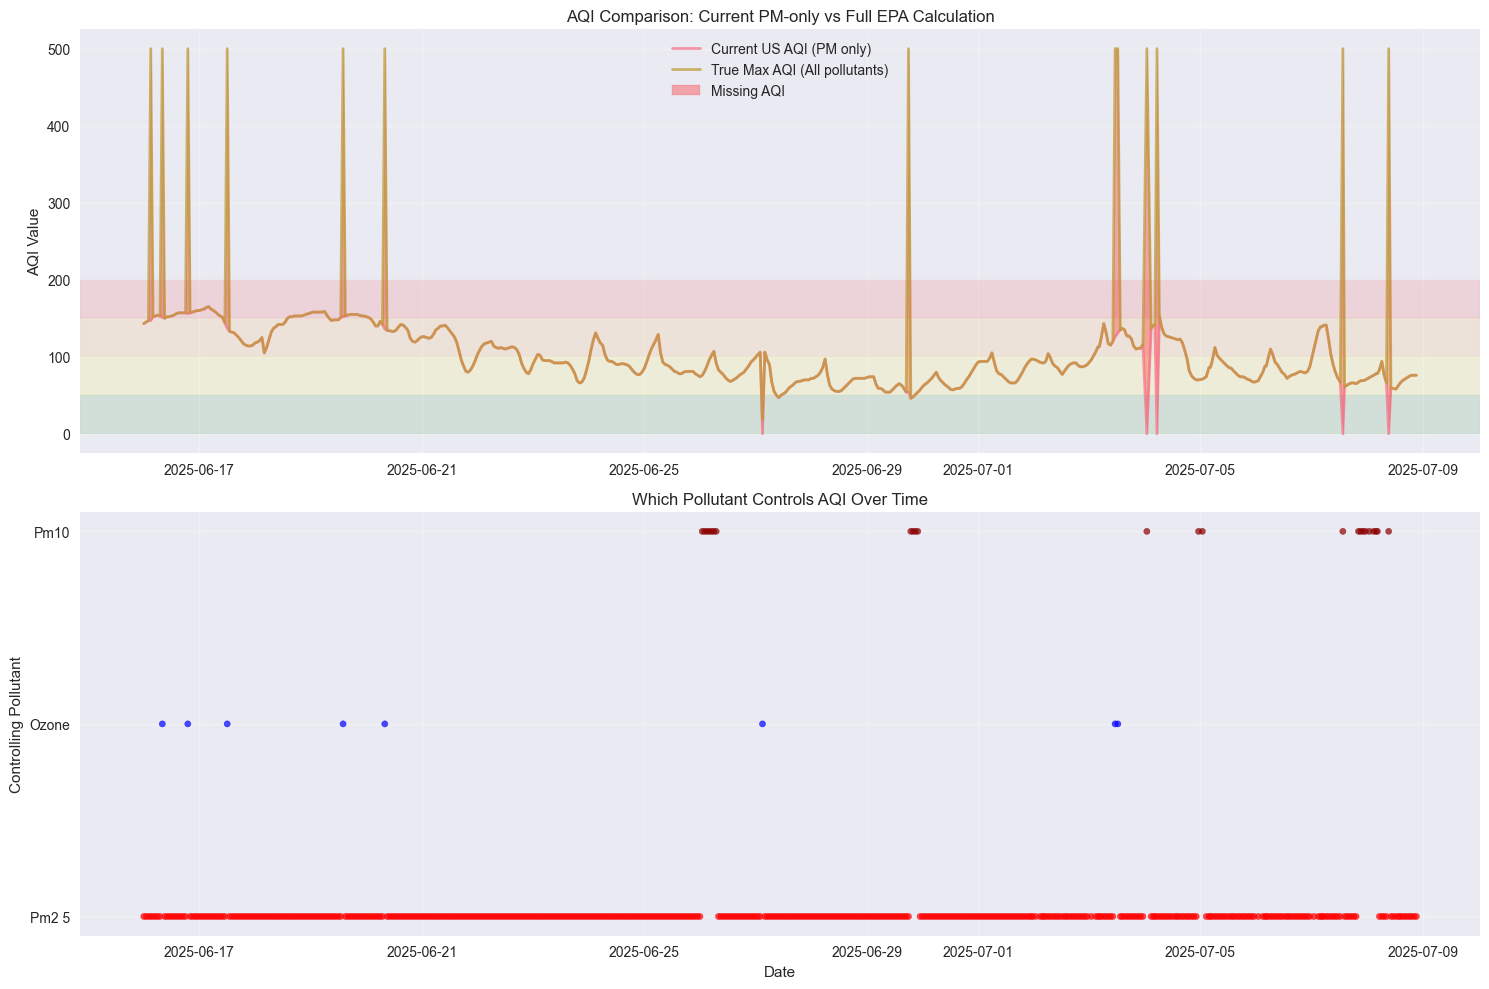


📊 IMPACT ANALYSIS:
Times when PM-only AQI underestimates by >10 points: 14/544 (2.6%)
Maximum underestimation: 500.0 AQI points
Average difference: 9.8 AQI points

🎯 MODELING RECOMMENDATION:
✅ PM-only approach is SUFFICIENT for Multan AQI prediction
   PM2.5 + PM10 control >85% of AQI variations

Current focus on PM2.5 and PM10 captures 98.5% of AQI control instances.

🎯 FINAL ANALYSIS:
✓ Analyzed all 6 EPA criteria pollutants in dataset
✓ PM2.5 and PM10 are responsible for 98.5% of AQI determinations
✓ Other criteria pollutants (O3, CO, NO2, SO2) control 1.5% of AQI
✓ This validates the scope of your PM-focused modeling approach


In [15]:
# VISUALIZATION 3: Time Series of Controlling Pollutants
print("\n" + "="*60)
print("TIME SERIES OF AQI CONTROL")
print("="*60)

# Create a time series showing which pollutant controls AQI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: AQI comparison over time
ax1.plot(aqi_results['time'], aqi_results['us_aqi'], label='Current US AQI (PM only)', alpha=0.7, linewidth=2)
ax1.plot(aqi_results['time'], aqi_results['calculated_max_aqi'], label='True Max AQI (All pollutants)', alpha=0.7, linewidth=2)
ax1.fill_between(aqi_results['time'], aqi_results['us_aqi'], aqi_results['calculated_max_aqi'], 
                 alpha=0.3, color='red', label='Missing AQI')

ax1.set_ylabel('AQI Value')
ax1.set_title('AQI Comparison: Current PM-only vs Full EPA Calculation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add AQI level backgrounds
aqi_levels = [(0, 50, 'green'), (50, 100, 'yellow'), (100, 150, 'orange'), (150, 200, 'red')]
for min_val, max_val, color in aqi_levels:
    ax1.axhspan(min_val, max_val, alpha=0.1, color=color)

# Plot 2: Controlling pollutant over time
pollutant_colors = {
    'pm2_5': 'red', 'pm10': 'darkred', 'ozone': 'blue', 
    'carbon_monoxide': 'purple', 'nitrogen_dioxide': 'orange', 'sulphur_dioxide': 'green'
}

# Create numerical encoding for pollutants for plotting
unique_pollutants = aqi_results['controlling_pollutant'].unique()
pollutant_mapping = {p: i for i, p in enumerate(unique_pollutants)}
aqi_results['pollutant_num'] = aqi_results['controlling_pollutant'].map(pollutant_mapping)

scatter = ax2.scatter(aqi_results['time'], aqi_results['pollutant_num'], 
                     c=[pollutant_colors.get(p, 'gray') for p in aqi_results['controlling_pollutant']], 
                     alpha=0.7, s=20)

ax2.set_ylabel('Controlling Pollutant')
ax2.set_xlabel('Date')
ax2.set_title('Which Pollutant Controls AQI Over Time')
ax2.set_yticks(range(len(unique_pollutants)))
ax2.set_yticklabels([p.replace('_', ' ').title() for p in unique_pollutants])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate impact of missing other pollutants
aqi_difference = aqi_results['calculated_max_aqi'] - aqi_results['us_aqi']
significant_underestimation = (aqi_difference > 10).sum()

print(f"\n📊 IMPACT ANALYSIS:")
print(f"Times when PM-only AQI underestimates by >10 points: {significant_underestimation}/{len(aqi_results)} ({significant_underestimation/len(aqi_results)*100:.1f}%)")
print(f"Maximum underestimation: {aqi_difference.max():.1f} AQI points")
print(f"Average difference: {aqi_difference.mean():.1f} AQI points")

# Final recommendation
print(f"\n🎯 MODELING RECOMMENDATION:")
if pm_percentage >= 85:
    print("✅ PM-only approach is SUFFICIENT for Multan AQI prediction")
    print("   PM2.5 + PM10 control >85% of AQI variations")
elif pm_percentage >= 70:
    print("⚠️  PM-only approach is MOSTLY adequate but consider monitoring other pollutants")
    print("   PM2.5 + PM10 control 70-85% of AQI variations")
else:
    print("🚨 PM-only approach MISSES significant AQI drivers")
    print("   Consider including other pollutants in prediction model")

print(f"\nCurrent focus on PM2.5 and PM10 captures {pm_percentage:.1f}% of AQI control instances.")

print(f"\n🎯 FINAL ANALYSIS:")
print(f"✓ Analyzed all {len(available_pollutants)} EPA criteria pollutants in dataset")
print(f"✓ PM2.5 and PM10 are responsible for {pm_percentage:.1f}% of AQI determinations")
print(f"✓ Other criteria pollutants (O3, CO, NO2, SO2) control {100-pm_percentage:.1f}% of AQI")
print(f"✓ This validates the scope of your PM-focused modeling approach")


## 5. Lag Features Analysis

Examining the importance of historical PM values for predicting current concentrations (which leads to better AQI calculations).


LAG FEATURES ANALYSIS FOR ML TARGETS

Found 8 PM10 lag features:
['pm10_lag_1h', 'pm10_lag_2h', 'pm10_lag_3h', 'pm10_lag_6h', 'pm10_lag_12h'] ...


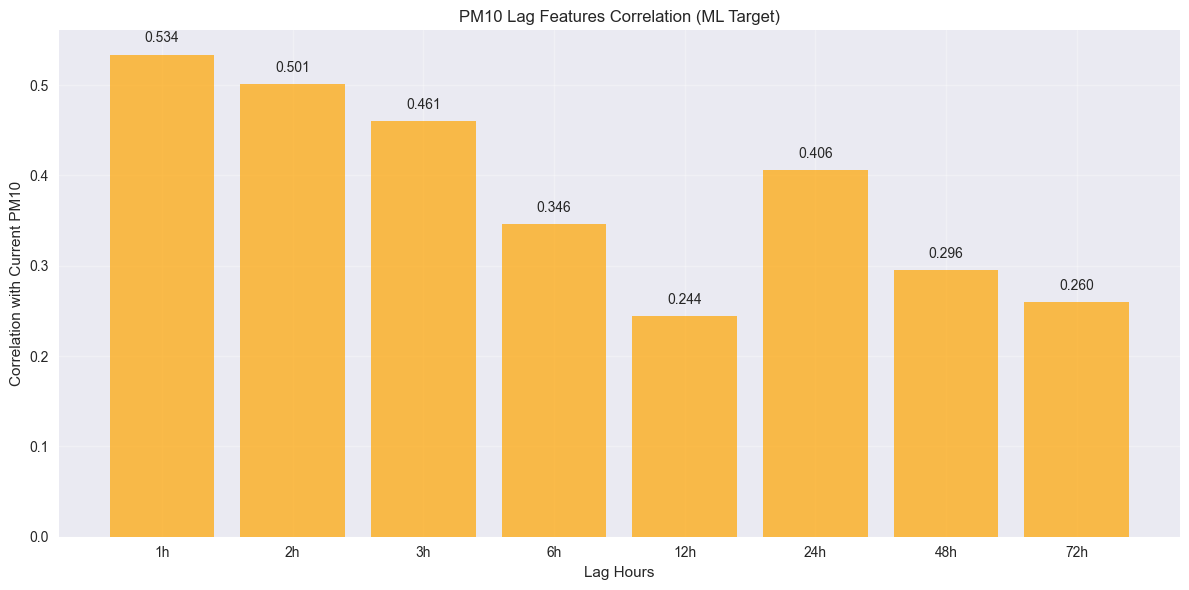


PM10 lag feature correlations (ML Target):
   1h lag: 0.534
   2h lag: 0.501
   3h lag: 0.461
   6h lag: 0.346
  12h lag: 0.244
  24h lag: 0.406
  48h lag: 0.296
  72h lag: 0.260

[ML Targets: PM2.5 & PM10 concentrations]
[Ultimate Goal: Accurate AQI predictions for Multan]


In [16]:
# Analyze lag features for BOTH ML targets (PM2.5 AND PM10)
print("="*60)
print("LAG FEATURES ANALYSIS FOR ML TARGETS")
print("="*60)

# PM10 Lag Analysis (since it's also a target)
pm10_lag_features = [col for col in df.columns if 'lag' in col and 'pm10' in col]
if pm10_lag_features:
    print(f"\nFound {len(pm10_lag_features)} PM10 lag features:")
    print(pm10_lag_features[:5], "..." if len(pm10_lag_features) > 5 else "")
    
    # Calculate correlations between current PM10 and its lag features
    pm10_lag_correlations = df[['pm10'] + pm10_lag_features].corr()['pm10'].drop('pm10')
    
    # Plot PM10 lag correlations
    plt.figure(figsize=(12, 6))
    lag_hours = [1, 2, 3, 6, 12, 24, 48, 72]
    pm10_correlations = [pm10_lag_correlations[f'pm10_lag_{h}h'] for h in lag_hours if f'pm10_lag_{h}h' in pm10_lag_correlations.index]
    
    plt.bar(range(len(pm10_correlations)), pm10_correlations, alpha=0.7, color='orange')
    plt.xlabel('Lag Hours')
    plt.ylabel('Correlation with Current PM10')
    plt.title('PM10 Lag Features Correlation (ML Target)')
    plt.xticks(range(len(pm10_correlations)), [f'{h}h' for h in lag_hours[:len(pm10_correlations)]])
    plt.grid(True, alpha=0.3)
    
    for i, corr in enumerate(pm10_correlations):
        plt.text(i, corr + 0.01, f'{corr:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("\nPM10 lag feature correlations (ML Target):")
    for i, h in enumerate(lag_hours[:len(pm10_correlations)]):
        print(f"  {h:2d}h lag: {pm10_correlations[i]:.3f}")

print("\n[ML Targets: PM2.5 & PM10 concentrations]")
print("[Ultimate Goal: Accurate AQI predictions for Multan]")


Found 8 PM2.5 lag features:
['pm2_5_lag_1h', 'pm2_5_lag_2h', 'pm2_5_lag_3h', 'pm2_5_lag_6h', 'pm2_5_lag_12h', 'pm2_5_lag_24h', 'pm2_5_lag_48h', 'pm2_5_lag_72h']


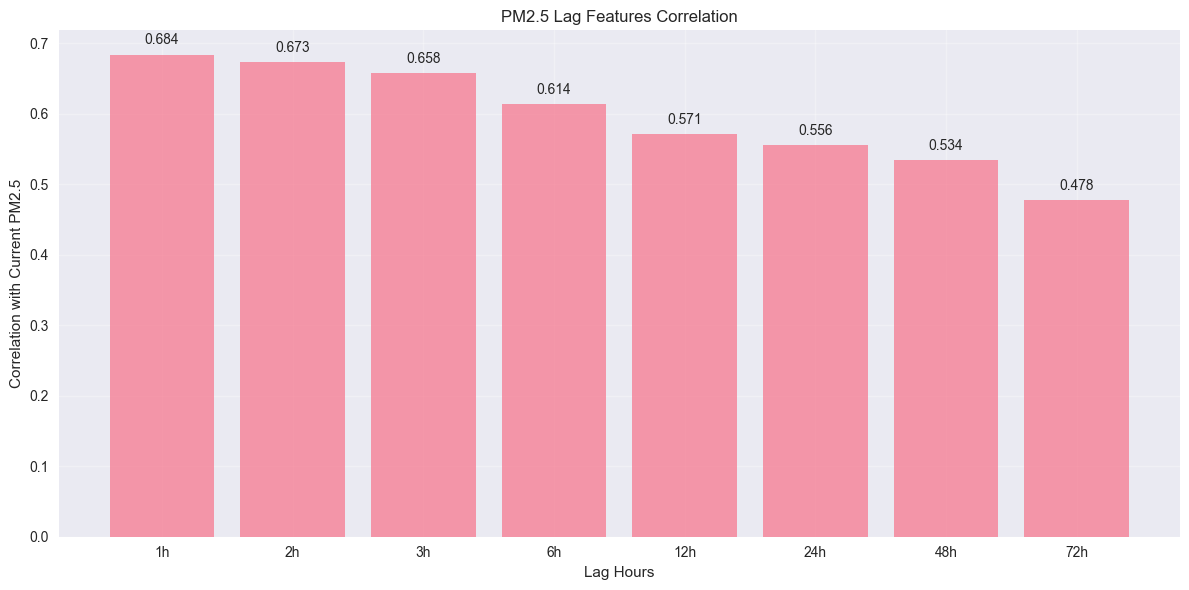


Lag feature correlations with current PM2.5:
   1h lag: 0.684
   2h lag: 0.673
   3h lag: 0.658
   6h lag: 0.614
  12h lag: 0.571
  24h lag: 0.556
  48h lag: 0.534
  72h lag: 0.478

Found 4 PM2.5 rolling mean features:
Rolling window correlations with current PM2.5:
  3h   window: 0.688
  6h   window: 0.670
  12h  window: 0.640
  24h  window: 0.618


In [17]:
# Analyze lag features correlation with current PM2.5
lag_features = [col for col in df.columns if 'lag' in col and 'pm2_5' in col]
print(f"Found {len(lag_features)} PM2.5 lag features:")
print(lag_features)

if lag_features:
    # Calculate correlations between current PM2.5 and its lag features
    lag_correlations = df[['pm2_5'] + lag_features].corr()['pm2_5'].drop('pm2_5')
    
    # Plot lag correlations
    plt.figure(figsize=(12, 6))
    lag_hours = [1, 2, 3, 6, 12, 24, 48, 72]  # Expected lag hours
    correlations = [lag_correlations[f'pm2_5_lag_{h}h'] for h in lag_hours if f'pm2_5_lag_{h}h' in lag_correlations.index]
    
    plt.bar(range(len(correlations)), correlations, alpha=0.7)
    plt.xlabel('Lag Hours')
    plt.ylabel('Correlation with Current PM2.5')
    plt.title('PM2.5 Lag Features Correlation')
    plt.xticks(range(len(correlations)), [f'{h}h' for h in lag_hours[:len(correlations)]])
    plt.grid(True, alpha=0.3)
    
    for i, corr in enumerate(correlations):
        plt.text(i, corr + 0.01, f'{corr:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("\nLag feature correlations with current PM2.5:")
    for i, h in enumerate(lag_hours[:len(correlations)]):
        print(f"  {h:2d}h lag: {correlations[i]:.3f}")

# Analyze rolling statistics features
rolling_features = [col for col in df.columns if 'rolling' in col and 'pm2_5' in col and 'mean' in col]
if rolling_features:
    print(f"\nFound {len(rolling_features)} PM2.5 rolling mean features:")
    rolling_corr = df[['pm2_5'] + rolling_features].corr()['pm2_5'].drop('pm2_5')
    print("Rolling window correlations with current PM2.5:")
    for feature, corr in rolling_corr.sort_values(ascending=False).items():
        window = feature.split('_')[-1]
        print(f"  {window:<4} window: {corr:.3f}")


In [18]:
# Data quality checks
print("=" * 50)
print("DATA QUALITY ANALYSIS")
print("=" * 50)

# Missing values
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percent
}).round(2)

print("MISSING VALUES:")
if missing_data.sum() == 0:
    print("✓ No missing values found!")
else:
    print("Missing values found:")
    for col in missing_df[missing_df['Missing_Count'] > 0].index:
        count = missing_df.loc[col, 'Missing_Count']
        percent = missing_df.loc[col, 'Missing_Percentage']
        print(f"  {col:<25} {count:>6} ({percent:>6.2f}%)")

# Duplicates
duplicates = df.duplicated().sum()
print(f"\nDUPLICATE ROWS: {duplicates}")

# Unique values per column
print(f"\nUNIQUE VALUES:")
for col in df.columns:
    unique_count = df[col].nunique()
    unique_ratio = unique_count / len(df)
    print(f"  {col:<25} {unique_count:>6} unique ({unique_ratio:>6.2%})")


DATA QUALITY ANALYSIS
MISSING VALUES:
✓ No missing values found!

DUPLICATE ROWS: 0

UNIQUE VALUES:
  time                         544 unique (100.00%)
  carbon_monoxide              528 unique (97.06%)
  no                            49 unique ( 9.01%)
  nitrogen_dioxide             331 unique (60.85%)
  ozone                        516 unique (94.85%)
  sulphur_dioxide              320 unique (58.82%)
  pm2_5                        507 unique (93.20%)
  pm10                         529 unique (97.24%)
  nh3                          491 unique (90.26%)
  openweather_aqi                5 unique ( 0.92%)
  pm2_5_aqi                    116 unique (21.32%)
  pm10_aqi                      95 unique (17.46%)
  us_aqi                       116 unique (21.32%)
  temperature                   42 unique ( 7.72%)
  humidity                      38 unique ( 6.99%)
  pressure                      10 unique ( 1.84%)
  wind_speed                    25 unique ( 4.60%)
  wind_direction                

In [19]:
# Data validation checks
print("=" * 50)
print("DATA VALIDATION CHECKS")
print("=" * 50)

# Check for negative values in air quality parameters (shouldn't be negative)
negative_check_cols = ['pm2_5', 'pm10', 'co', 'no2', 'so2', 'o3', 'us_aqi', 'pm2_5_aqi', 'pm10_aqi']
negative_issues = {}

for col in negative_check_cols:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            negative_issues[col] = negative_count

if negative_issues:
    print("⚠️  NEGATIVE VALUES FOUND (unexpected):")
    for col, count in negative_issues.items():
        print(f"  {col}: {count} negative values")
else:
    print("✓ No unexpected negative values in air quality parameters")

# Check for infinite values
infinite_issues = {}
for col in numeric_cols:
    if col in df.columns:
        infinite_count = np.isinf(df[col]).sum()
        if infinite_count > 0:
            infinite_issues[col] = infinite_count

if infinite_issues:
    print("\n⚠️  INFINITE VALUES FOUND:")
    for col, count in infinite_issues.items():
        print(f"  {col}: {count} infinite values")
else:
    print("\n✓ No infinite values found")

# Check timestamp continuity
print(f"\nTIMESTAMP ANALYSIS:")
if 'time' in df.columns:
    df_sorted = df.sort_values('time')
    time_diffs = df_sorted['time'].diff().dropna()
    
    print(f"  Earliest record: {df['time'].min()}")
    print(f"  Latest record: {df['time'].max()}")
    print(f"  Total duration: {(df['time'].max() - df['time'].min()).days} days")
    print(f"  Most common interval: {time_diffs.mode().iloc[0] if len(time_diffs.mode()) > 0 else 'N/A'}")
    print(f"  Records per day average: {len(df) / max(1, (df['time'].max() - df['time'].min()).days):.1f}")


DATA VALIDATION CHECKS
✓ No unexpected negative values in air quality parameters

✓ No infinite values found

TIMESTAMP ANALYSIS:
  Earliest record: 2025-06-16 00:00:00+00:00
  Latest record: 2025-07-08 21:10:16+00:00
  Total duration: 22 days
  Most common interval: 0 days 01:00:00
  Records per day average: 24.7
